In [1]:
import matplotlib.pyplot as plt
from glob import glob
import PIL

import torch
from torchvision import transforms
from torchinfo import summary

from utils_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from utils_evaluation import show_misclassified
from utils_dataset import plot_sample_images, walk_through_dir, split_dataset, create_dataloaders
from utils_helper import set_all_seeds, set_up_device, clear_cuda_memory, save_model, load_model

from model_builder import BrainTumorModel
from train import train_model

from config import settings

c:\Users\Joanna\Desktop\Projects\brain-mri-classification\.venv\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Configurations

In [2]:
set_all_seeds(123)
DEVICE = set_up_device()
BATCH_SIZE = settings.config['batch_size']
NUM_WORKERS = settings.config['num_workers']
NUM_EPOCHS = settings.config['num_epochs']

# Preparation

In [ ]:
# Split Dataset
split_dataset(train_set=0.8, valid_set=0.1)

# Sample Images

There are total of 98 negative and 155 positive images.
- Of these 98 negatives, 78 is used for training, 9 for validation and 11 for testing
- Of the 155 positives, 124 is used for training, 15 for validation and 16 for testing

In [26]:
walk_through_dir(settings.DATASET_DIR)

There are 4 directories and 1 images in 'C:\Users\Joanna\Desktop\Projects\brain-mri-classification\data'.
There are 2 directories and 0 images in 'C:\Users\Joanna\Desktop\Projects\brain-mri-classification\data\brain_tumor_dataset'.
There are 0 directories and 98 images in 'C:\Users\Joanna\Desktop\Projects\brain-mri-classification\data\brain_tumor_dataset\no'.
There are 0 directories and 155 images in 'C:\Users\Joanna\Desktop\Projects\brain-mri-classification\data\brain_tumor_dataset\yes'.
There are 2 directories and 0 images in 'C:\Users\Joanna\Desktop\Projects\brain-mri-classification\data\test'.
There are 0 directories and 11 images in 'C:\Users\Joanna\Desktop\Projects\brain-mri-classification\data\test\no'.
There are 0 directories and 16 images in 'C:\Users\Joanna\Desktop\Projects\brain-mri-classification\data\test\yes'.
There are 2 directories and 0 images in 'C:\Users\Joanna\Desktop\Projects\brain-mri-classification\data\train'.
There are 0 directories and 78 images in 'C:\Users\J

Example of negative and positive images together with their image sizes

Array Dimensions (201, 173, 3)
Array Dimensions (251, 201, 3)
Array Dimensions (217, 232, 3)
Array Dimensions (338, 276, 3)
Array Dimensions (221, 228, 3)


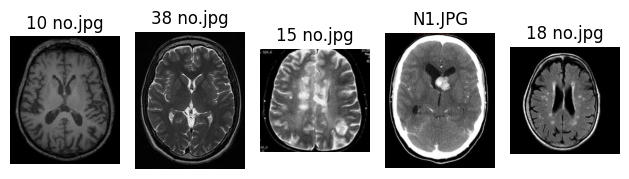

In [27]:
plot_sample_images(5, 'no')

Array Dimensions (512, 512, 3)
Array Dimensions (380, 310, 3)
Array Dimensions (251, 201, 3)
Array Dimensions (350, 272, 3)
Array Dimensions (960, 781, 3)


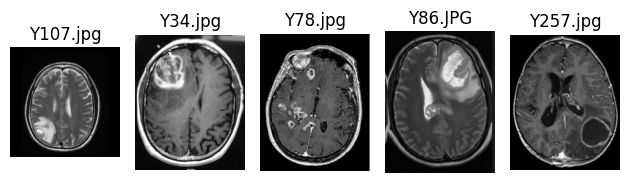

In [28]:
plot_sample_images(5, 'yes')

# Create DataLoaders

In [41]:
training_transform = transforms.Compose([
    transforms.Resize(size=(225, 225)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

testing_transform = transforms.Compose([
    transforms.Resize(size=(225, 225)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [42]:
train_dataloader, valid_dataloader, test_dataloader, class_names = create_dataloaders(
    train_transform=training_transform,
    test_transform=testing_transform,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

Image batch dimensions: torch.Size([16, 1, 225, 225])
Image label dimensions: torch.Size([16])


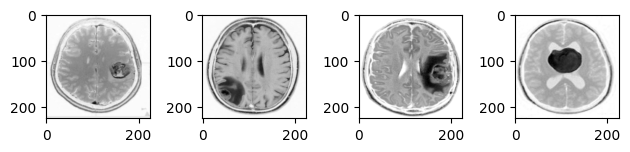

In [43]:
# Image after transformation
for images, labels in train_dataloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(images[i].view(225, 225).numpy(), cmap='binary')
    
plt.tight_layout()

In [44]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([16, 1, 225, 225]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])


# Model Architecture

In [45]:
model = BrainTumorModel(input_shape=1, #black and white,
                        output_shape=len(class_names)).to(DEVICE)

model

BrainTumorModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.5, inplace=False)
    (4): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout2d(p=0.5, inplace=False)
    (8): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=760384, out_features=2, bias=True)
  )
)

In [48]:
summary(model=model,
        input_size=(16, 1, 225, 225),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
BrainTumorModel (BrainTumorModel)        [16, 1, 225, 225]         [16, 2]                   --                        True
├─Sequential (conv_block_1)              [16, 1, 225, 225]         [16, 64, 109, 109]        --                        True
│    └─Conv2d (0)                        [16, 1, 225, 225]         [16, 64, 223, 223]        640                       True
│    └─BatchNorm2d (1)                   [16, 64, 223, 223]        [16, 64, 223, 223]        128                       True
│    └─ReLU (2)                          [16, 64, 223, 223]        [16, 64, 223, 223]        --                        --
│    └─Dropout2d (3)                     [16, 64, 223, 223]        [16, 64, 223, 223]        --                        --
│    └─Conv2d (4)                        [16, 64, 223, 223]        [16, 256, 221, 221]       147,712                   True
│    └─

In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                                                        mode='min',
#                                                        patience=2,
#                                                        factor=0.1,
#                                                        verbose=True)

In [50]:
clear_cuda_memory()

# Train Model

In [51]:
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_dataloader,
    valid_loader=valid_dataloader,
    test_loader=test_dataloader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=1)

Epoch: 001/050 | Batch 0000/0013 | Loss: 0.6928
Epoch: 001/050 | Batch 0001/0013 | Loss: 1.8251
Epoch: 001/050 | Batch 0002/0013 | Loss: 1.1016
Epoch: 001/050 | Batch 0003/0013 | Loss: 0.7147
Epoch: 001/050 | Batch 0004/0013 | Loss: 1.8007
Epoch: 001/050 | Batch 0005/0013 | Loss: 1.3471
Epoch: 001/050 | Batch 0006/0013 | Loss: 0.6220
Epoch: 001/050 | Batch 0007/0013 | Loss: 0.8237
Epoch: 001/050 | Batch 0008/0013 | Loss: 1.3170
Epoch: 001/050 | Batch 0009/0013 | Loss: 0.8819
Epoch: 001/050 | Batch 0010/0013 | Loss: 0.8527
Epoch: 001/050 | Batch 0011/0013 | Loss: 0.7045
Epoch: 001/050 | Batch 0012/0013 | Loss: 0.5955
Epoch: 001/050 | Train: 0.62% | Validation: 0.67%
Time elapsed: 0.39 min
Epoch: 002/050 | Batch 0000/0013 | Loss: 0.6642
Epoch: 002/050 | Batch 0001/0013 | Loss: 1.6794
Epoch: 002/050 | Batch 0002/0013 | Loss: 0.5086
Epoch: 002/050 | Batch 0003/0013 | Loss: 0.5956
Epoch: 002/050 | Batch 0004/0013 | Loss: 0.1987
Epoch: 002/050 | Batch 0005/0013 | Loss: 0.3674
Epoch: 002/050 

# Save Model

In [ ]:
save_model(model=model, target_dir="models", model_name="model.pt")
save_model(model=optimizer, target_dir="models", model_name="optimizer.pt")
#save_model(model=scheduler, target_dir="models", model_name="scheduler.pt")

In [ ]:
#load_model(model=model, target_dir="models", model_name="model.pt")
#load_model(model=optimizer, target_dir="models", model_name="optimizer.pt")

# Evaluation

The training loss decreased overtime and stabilises at around epoch 30

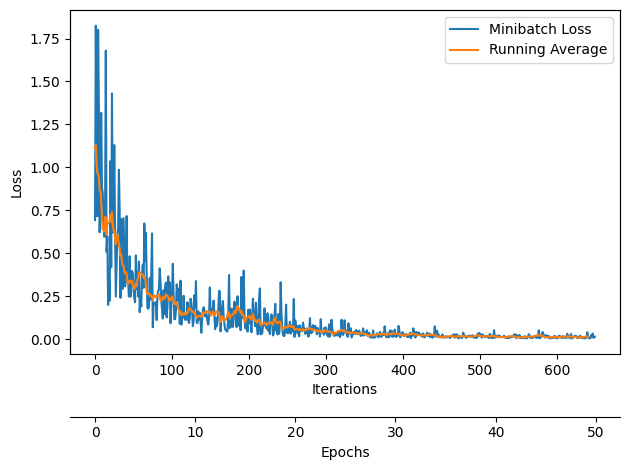

In [52]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=50,
                   iter_per_epoch=len(train_dataloader),
                   results_dir=None,
                   averaging_iterations=10)

Looking at the training and validation accuracy, we can see that there are signs of overfitting.

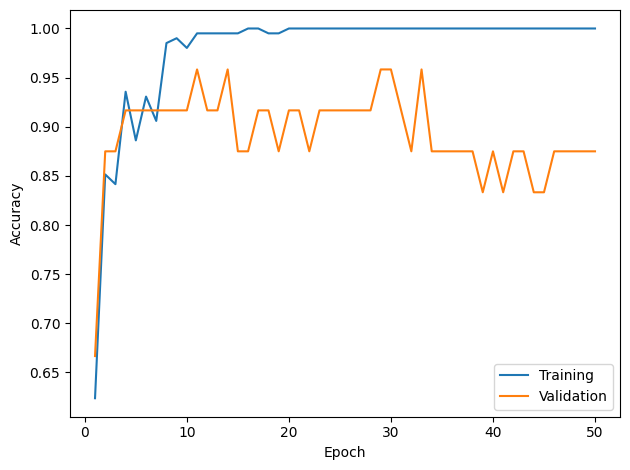

In [53]:
plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.show()

Let's take a look at some of the results

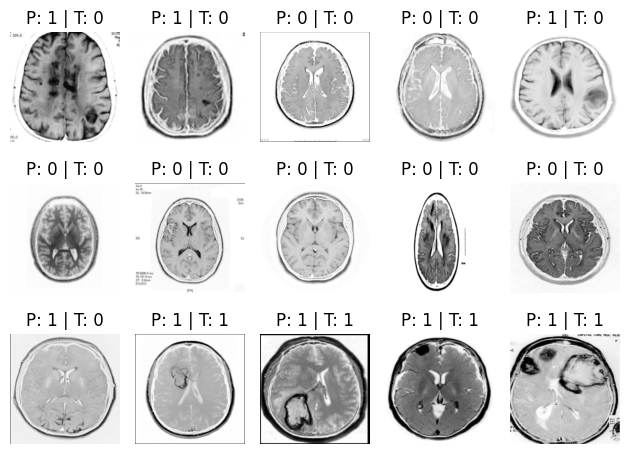

In [54]:
model.cpu()
show_examples(model=model, data_loader=test_dataloader)

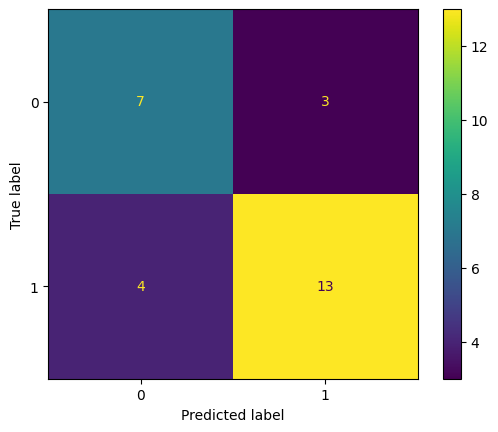

In [55]:
plot_confusion_matrix(model=model,
                      data_loader=test_dataloader,
                      device=DEVICE)

Let's look at the misclassified images to have an idea of what we could improve on

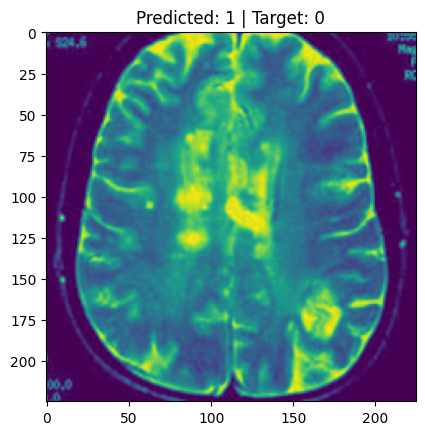

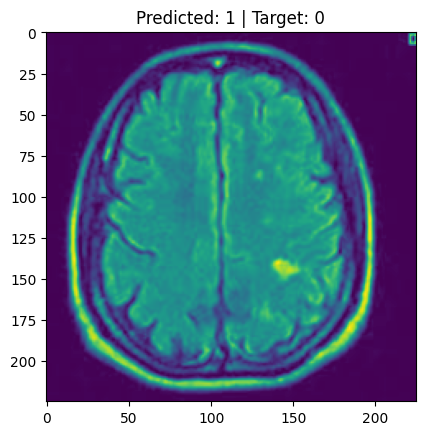

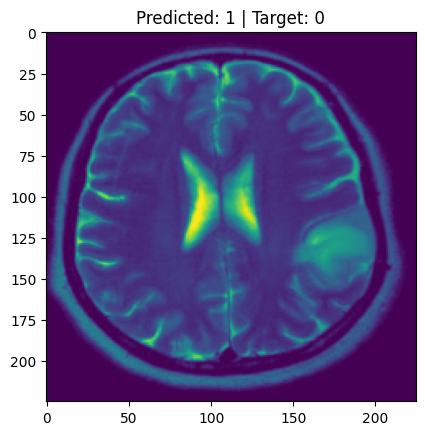

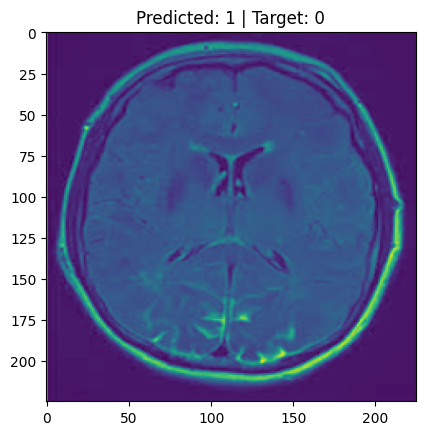

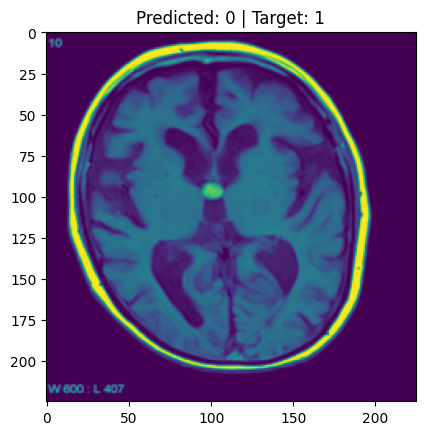

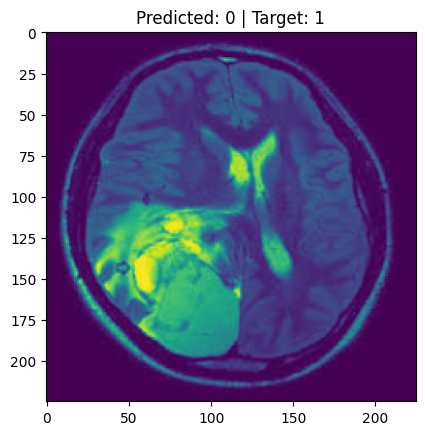

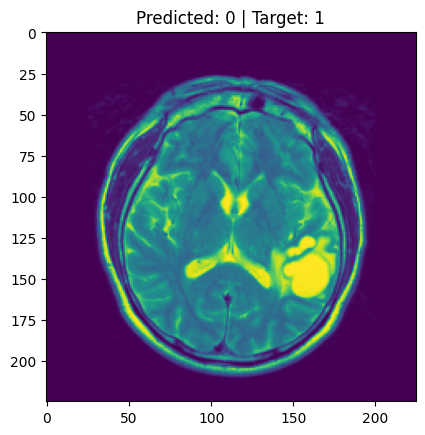

In [56]:
show_misclassified(model=model,
                   data_loader=test_dataloader,
                   device=DEVICE)